#Week 6: Image segmentation, curve evolution, level sets, active contours

https://github.com/burakbayramli/classnotes/tree/master/pde/pde_level

http://ascratchpad.blogspot.com/2011/01/level-sets-and-image-segmentation-with.html

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

import cv2
import scipy.ndimage.filters

## The image to segment

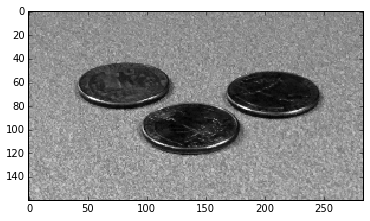

In [2]:
# use coins
img_name = 'images/coins_ellipse.jpg'
img_color = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
#scale & convert to grays
v_scaling = 160./img_color.shape[0]
h_scaling = v_scaling #80./img_color.shape[1]
img_color_scaled = cv2.resize(img_color, dsize=(0,0), fx=h_scaling, fy=v_scaling)
img = cv2.cvtColor(img_color_scaled, cv2.COLOR_RGB2GRAY).astype(np.float)

imgplt = plt.imshow(img, cmap=cm.Greys_r, interpolation="nearest")

##Create edge stopper

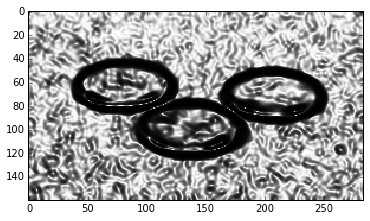

In [3]:
def get_g(img, sigma=2):
    img_smooth =  scipy.ndimage.filters.gaussian_filter(img, sigma)
    grad_img_smooth = np.gradient(img_smooth)
    grad_img_smooth_abs = np.sqrt(grad_img_smooth[1]**2 + grad_img_smooth[0]**2)
    g = 1 / (1 + grad_img_smooth_abs**2)
    return g

g = get_g(img)
imgplt = plt.imshow(g, cmap=cm.Greys_r, interpolation="nearest")

##Create initial phi

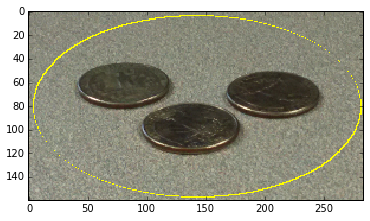

In [4]:
# Create Square
h, w = img.shape
c0 =  1.0
w0 = 4
phi0 = -c0 * np.ones((h, w))
cv2.ellipse(phi0, center=(w/2, h/2), axes=(w/2-w0, h/2-w0), angle=0, startAngle=0, endAngle=360,color=c0, thickness=-1)

# contour funtion
def contour(phi):
    sign = np.sign(phi)
    sign[sign == 0] = 1
    sign[1:, 1:] = (1 - sign[1:,1:] * sign[:-1,:-1])/2
    sign[:, :1] = 0
    sign[:1, :] = 0
    return sign

# Create image with contour
def show_shapes(img_color, phi, ccolor=(255,255,0)):
    #imgplt = plt.imshow(phi0, cmap='gray', interpolation="nearest")
    c = cv2.resize(contour(phi), dsize=(img_color.shape[1], img_color.shape[0]))
    i = img_color.copy()
    i[np.where(c != 0)] = ccolor
    return i
    
imgplt = plt.imshow(show_shapes(img_color_scaled, phi0), interpolation="nearest")

##dphi/dt

In [5]:
def dphi_dt(phi, motion='curvature', g=1):
    # Gradient
    grad = np.gradient(phi)
    grad_abs = np.sqrt(grad[0]**2 + grad[1]**2)
    # Norm.
    norm = grad/(grad_abs + (grad_abs==0))
    # Divergence
    div = np.gradient(norm[0])[0] + np.gradient(norm[1])[1]
    # Curvature.
    k = div   
    
    k_term = g * k * grad_abs
    const_term = -1 *g * grad_abs
    g_term = np.gradient(g)[0] * grad[0]  + np.gradient(g)[1] * grad[1]
    
    dPhiBydT = k_term + const_term + g_term  
    return dPhiBydT 


##Iterate

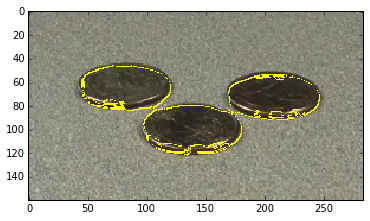

In [6]:
n_iter = 300
iter_capture = 5
phi = phi0.copy()
dt = 1.

img_sequence = []

for i in range(n_iter):
    phi = phi + dt * dphi_dt(phi, g= g*np.ones_like(phi))
    # frame capture
    if i % iter_capture == 0:
        img_sequence.append(show_shapes(img_color_scaled, phi))

imgplt = plt.imshow(img_sequence[-1], interpolation="nearest")

##Write animated GIF
`images2gif` from: https://github.com/rec/echomesh/blob/master/code/python/external/images2gif.py


In [7]:
from images2gif import writeGif
gif_out = img_name.replace('.jpg', '_segment_animated.gif')
writeGif(gif_out, img_sequence, duration=.25)

##And the Result:
![A](https://raw.githubusercontent.com/rmetchev/IVP-Python/master/images/coins_ellipse_segment_animated.gif)

#Some application: Send Snufkin to Jakku

##Snufkin

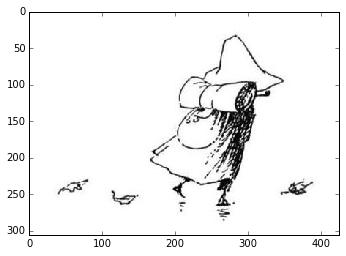

In [114]:
snufkin_color = None
snufkin = cv2.cvtColor(cv2.imread('images/snufkin.jpg'), cv2.COLOR_BGR2RGB)
imgplt = plt.imshow(snufkin, interpolation="nearest")

##Jakku

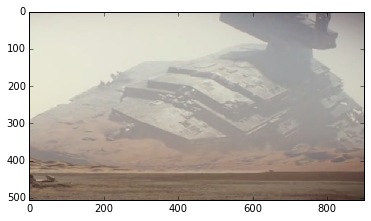

In [136]:
jakku = cv2.cvtColor(cv2.imread('images/jakku.jpg'), cv2.COLOR_BGR2RGB)
imgplt = plt.imshow(jakku, interpolation="nearest")

##Create phi

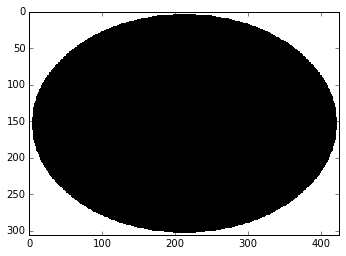

In [122]:
# Create phi
h, w = snufkin.shape[:2]
c0 =  1.0
w0 = 4
phi0 = -c0 * np.ones((h, w))
cv2.ellipse(phi0, center=(w/2, h/2), axes=(w/2-w0, h/2-w0), angle=0, startAngle=0, endAngle=360,color=c0, thickness=-1)
imgplt = plt.imshow(-phi0, cmap=cm.Greys_r, interpolation="nearest")

Overlay phi on shape

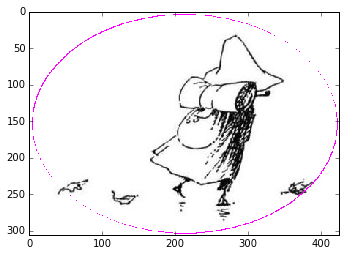

In [124]:
imgplt = plt.imshow(show_shapes(snufkin, phi0, ccolor=(255,0,255)), interpolation="nearest")

##Create edge stopper

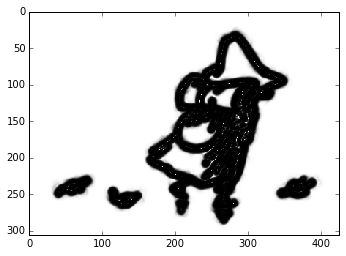

In [125]:
snufkin_bw = cv2.cvtColor(snufkin, cv2.COLOR_RGB2GRAY).astype(np.float)
g = get_g(snufkin_bw, sigma=2)
imgplt = plt.imshow(g, cmap=cm.Greys_r, interpolation="nearest")

##Segmentation with level set method

In [126]:
n_iter = 200
iter_capture = 5
phi = phi0.copy()
dt = 1.

img_sequence = []
phi_sequence = []

for i in range(n_iter):
    phi = phi + dt * dphi_dt(phi, g=g)
    # frame capture
    if i % iter_capture == 0:
        img_sequence.append(show_shapes(snufkin, phi, ccolor=(255,0,255)))
        phi_shape = phi.copy()
        phi_shape[phi_shape >= 0] = 0
        phi_shape[phi_shape < 0] = 1
        phi_sequence.append(phi_shape)

__Final segmentation__

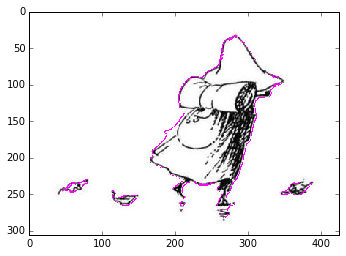

In [127]:
imgplt = plt.imshow(img_sequence[-1], interpolation="nearest")

__Final phi represents the stencil__

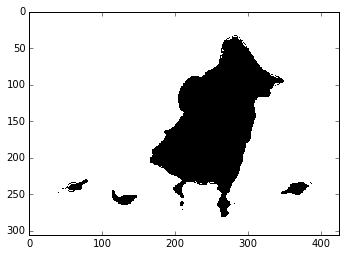

In [128]:
imgplt = plt.imshow(phi_sequence[-1], cmap=cm.Greys_r, interpolation="nearest")

__Write out animated GIFs showing curve evolution__

In [142]:
writeGif('images/snufkin_segmented.gif', img_sequence, duration=.35)
writeGif('images/snufkin_shape.gif', phi_sequence, duration=.35)

![A](https://raw.githubusercontent.com/rmetchev/IVP-Python/master/images/snufkin_segmented.gif)
![A](https://raw.githubusercontent.com/rmetchev/IVP-Python/master/images/snufkin_shape.gif)

##Snufkin lands on Jakku

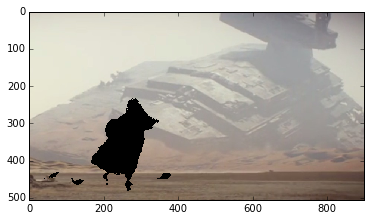

In [140]:
# flip images to align bottoms
snufkin_on_jakku = jakku[::-1,:,:].copy()
snufkin_tmp = snufkin[::-1,:,:]
snufkin_phi_sequence = phi_sequence[-1][::-1,:]

# stencil 
location_of_snufkin = np.where(snufkin_phi_sequence == 0)
snufkin_on_jakku[location_of_snufkin] = (0,0,0)
# show stencil
imgplt = plt.imshow(snufkin_on_jakku[::-1,:,:], interpolation="nearest")

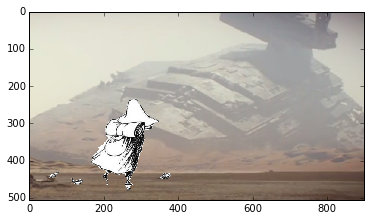

In [141]:
# stencil snufkin onto Jakku
snufkin_on_jakku[location_of_snufkin] = snufkin_tmp[location_of_snufkin]

# undo flip
snufkin_on_jakku = snufkin_on_jakku[::-1,:,:]
#write out
cv2.imwrite('images/snufkin_on_jakku.jpg', cv2.cvtColor(snufkin_on_jakku, cv2.COLOR_RGB2BGR))
imgplt = plt.imshow(snufkin_on_jakku, interpolation="nearest")